In [1]:
#from google.colab import drive 
#drive.mount('/content/gdrive')

In [2]:
# Import libraries required for the code

from collections import Counter
import re
import time

In [3]:
#import gensim
#import gensim.downloader as api

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from scipy.sparse import hstack
from scipy.stats import describe

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Set theme of seaborn 
sns.set()

## Load Training Data and Testing Data

In [7]:
#Train data
train_df = pd.read_csv("new_data_train.csv", sep='\t', index_col=0)
#Validation data
test_df = pd.read_csv("new_data_test.csv", sep='\t', index_col=0)

In [8]:
train_df.head()

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40


In [9]:
train_df.shape, test_df.shape

((9929, 22), (2483, 22))

In [10]:
train_df.flagged.value_counts()

0    4994
1    4935
Name: flagged, dtype: int64

In [11]:
test_df.flagged.value_counts()

1    1271
0    1212
Name: flagged, dtype: int64

In [12]:
#Check for nan

In [13]:
nan_rows = train_df[train_df['reviewContent'].isnull()]
nan_rows

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
15972,vPx7Ga3vAB7ZLfZsQChlSA,QasfZU1HgCW4LNU8AFFfwg,LMaoM2Ue2BR_HI9ba3JsZg,8/23/2012,4,0,NaN,0,Robert H.,"Denver, CO",...,84,2,16,23,6,9,1,2,4.0,1
25462,ln1j0sucN56GF7NaXqvtkQ,FezvtjI9VD4PZR0vIq-9IQ,43rd1LKcZRIunySzbMsyLQ,9/12/2007,5,0,NaN,1,Txema G.,"Chicago, IL",...,1,0,0,0,1,0,0,0,4.5,1
20728,f83DnEX60KDNk9rqInjWwg,TPOQUpDTdFMPeZwO2nOWQA,O6uWHgJzylSjWjPSJKGhnQ,12/16/2007,3,0,NaN,1,ozlem v.,"Chicago, IL",...,2,0,1,1,0,0,0,0,4.0,1


In [14]:
train_df = train_df[~train_df['reviewContent'].isnull()]
train_df

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,dK2U-orHZg9ps2g8BRwakA,tPufvUuxXLJOMYQ7gzsMVA,Z2nOMPedr7XYhgYhILJjEA,12/4/2011,4,1,confirming owner s helpful suggestion trick ab...,0,Andrew AndroidTopp T.,"Aurora, IL",...,518,79,538,222,258,111,16,15,4.0,83
20930,ENlbumgWkN3PE97iH7YWuQ,qKF-OwPxog4HdFuPlydllg,tW2jfL-qMccAYZSghPBbHA,1/1/2009,5,0,this best pizza chicago possibly world they am...,1,Rebecca G.,"Chicago, IL",...,3,0,2,0,0,0,0,0,4.0,46
2420,ubhEydMPnwVHLt9IpVi28w,YqVj5efZc2uGwDmgPbPWKA,Z2nOMPedr7XYhgYhILJjEA,1/6/2009,5,0,i love place great beer great service fantasti...,1,Brent C.,"Chicago, IL",...,8,0,0,0,0,0,0,0,4.0,16
3090,0NuFEa_gIMKbj0wsncFlvw,VKIlQivcuKidmmc2EXSlqA,sfWMOqUEp8S2adDeJp7Kzg,7/21/2010,4,0,i always passed place never chance come in fin...,1,Karina Kari A.,"Oak Park, IL",...,2,0,0,0,0,1,1,0,4.0,125


In [15]:
train_df.shape

(9926, 22)

### Dropping Non Textual Features

In [16]:
train_df = train_df[['reviewContent','flagged']]
train_df

,reviewContent,flagged
6010,as new resident chicago los angeles i mission ...,1
6566,great place rarely wait fairly easy find parki...,0
21349,back bar makes feel though transported china s...,1
10370,hands one favorite tourist restaurants city th...,0
6011,service impeccable staff helpful owner works h...,1
...,...,...
2072,confirming owner s helpful suggestion trick ab...,0
20930,this best pizza chicago possibly world they am...,1
2420,i love place great beer great service fantasti...,1
3090,i always passed place never chance come in fin...,1


In [17]:
test_df = test_df[['reviewContent','flagged']]
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


## Defining Evaluation Metric

In [18]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [19]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [20]:
test_y = test_df.flagged
test_y

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

## 1. Baseline Model: Predicting each value as the majority class ( genuine review )

In [21]:
train_df.flagged.value_counts()

0    4993
1    4933
Name: flagged, dtype: int64

In [22]:
#As we saw before, 0 ('genuine') is the majority class. Lets begin by predicting everything as 0 ('genuine').
preds_test = np.zeros(len(test_df))



In [23]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.4881192106322996
Precision score is: 0.0
Recall score is: 0.0
F1 score is: 0.0


In [24]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[1212    0]
 [1271    0]]


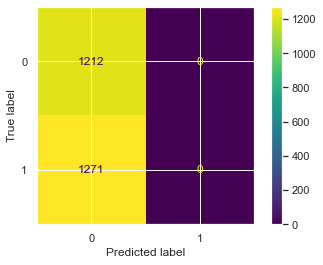

In [25]:


cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

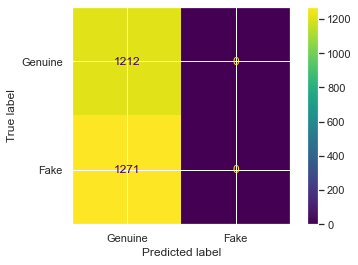

In [26]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [27]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 1271
TP: 0
TN: 1212
FP: 0


In [28]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1212
           1       0.00      0.00      0.00      1271

    accuracy                           0.49      2483
   macro avg       0.24      0.50      0.33      2483
weighted avg       0.24      0.49      0.32      2483



In [29]:
# Get baseline results
baseline_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
baseline_results

{'accuracy': 48.81192106322996, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

## 3. Featurization of Textual Sentences into Numeric Vectors

**There are three techniques we would use for vectorization:**


**1. Bag Of Words (Unigram, Bigram..)**

**2. TF-IDF**

**3. Word2Vec**

In [30]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chirag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
#Load Stopwords from NLTK. We will use these to clean our text
stop_words = set(stopwords.words("english"))

In [32]:
train_df

,reviewContent,flagged
6010,as new resident chicago los angeles i mission ...,1
6566,great place rarely wait fairly easy find parki...,0
21349,back bar makes feel though transported china s...,1
10370,hands one favorite tourist restaurants city th...,0
6011,service impeccable staff helpful owner works h...,1
...,...,...
2072,confirming owner s helpful suggestion trick ab...,0
20930,this best pizza chicago possibly world they am...,1
2420,i love place great beer great service fantasti...,1
3090,i always passed place never chance come in fin...,1


In [33]:
y_train = train_df['flagged']
y_train

6010     1
6566     0
21349    1
10370    0
6011     1
        ..
2072     0
20930    1
2420     1
3090     1
22414    0
Name: flagged, Length: 9926, dtype: int64

In [34]:
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


In [35]:
y_test = test_df['flagged']
y_test

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

In [36]:
test_y = y_test
test_y

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

## 3.b) TF-IDF on review text

In [37]:
unigram = (1, 1)
bigram = (1, 2)
trigram = (1, 3)

#we are trying 2 words at a time
n_gram = bigram

In [39]:
#Tf-idf for vectorization
tfidf_train = TfidfVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
)

#Tf-idf on review text in train data
X_train = tfidf_train.fit_transform(train_df["reviewContent"])

#get features we derived from training data
train_vocab = tfidf_train.get_feature_names()

#use those features to vectorize cross val data as well
tfidf_dev = TfidfVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
    vocabulary=train_vocab, #features we got from training
)


#BoW on review text in test data
X_test = tfidf_dev.fit_transform(test_df["reviewContent"])

In [40]:
X_train.shape

(9926, 80632)

In [41]:
X_test.shape

(2483, 80632)

In [42]:
y_train.shape

(9926,)

In [43]:
y_test.shape

(2483,)

## 4. Model Building

In [44]:
model_results = {}

In [45]:
#Add Baseline
model_results["BASELINE"] = baseline_results

In [46]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0}}

### a) Logistic Regression

In [47]:
lr = LogisticRegression(max_iter=7600,random_state = 1)
_ = lr.fit(X_train, y_train)

#predictions on test data
preds_test= lr.predict(X_test)

In [48]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6790173177607732
Precision score is: 0.6984924623115578
Recall score is: 0.6561762391817466
F1 score is: 0.6766734279918863


In [49]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[852 360]
 [437 834]]


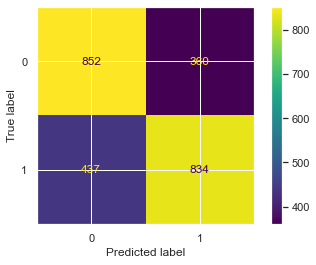

In [50]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

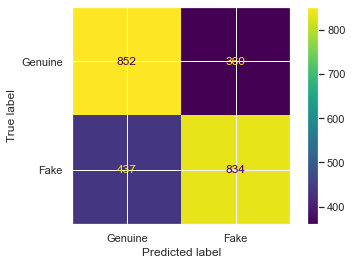

In [51]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [52]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 437
TP: 834
TN: 852
FP: 360


In [53]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1212
           1       0.70      0.66      0.68      1271

    accuracy                           0.68      2483
   macro avg       0.68      0.68      0.68      2483
weighted avg       0.68      0.68      0.68      2483



In [54]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6795732681057248


In [55]:
# Get baseline results
lr_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
lr_results

{'accuracy': 67.90173177607733,
 'precision': 0.6984924623115578,
 'recall': 0.6561762391817466,
 'f1': 0.6766734279918863}

In [56]:
model_results["Logistic Regression"] = lr_results

In [57]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863}}

### b) Decision Tree Classifier

In [58]:
dt = DecisionTreeClassifier(random_state = 1)
_ = dt.fit(X_train, y_train)

#predictions on test data
preds_test= dt.predict(X_test)


In [59]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5867901731776077
Precision score is: 0.59592795614722
Recall score is: 0.5987411487018096
F1 score is: 0.597331240188383


In [60]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[696 516]
 [510 761]]


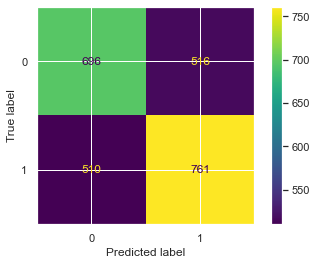

In [61]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

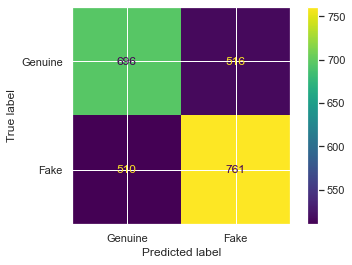

In [62]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [63]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 510
TP: 761
TN: 696
FP: 516


In [64]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1212
           1       0.60      0.60      0.60      1271

    accuracy                           0.59      2483
   macro avg       0.59      0.59      0.59      2483
weighted avg       0.59      0.59      0.59      2483



In [65]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5864992872221919


In [66]:
# Get baseline results
dt_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
dt_results

{'accuracy': 58.679017317760774,
 'precision': 0.59592795614722,
 'recall': 0.5987411487018096,
 'f1': 0.597331240188383}

In [67]:
model_results["Decision Tree"] = dt_results

In [68]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383}}

We will now try to do some hyperparameter tuning on Decision Tree

In [71]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

dt2 = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=30, n_jobs=-1)

search = dt2.fit(X_train, y_train)

search.best_params_

{'min_samples_split': 20,
 'max_leaf_nodes': 32,
 'max_features': 0.8,
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [73]:
optimal_params = search.best_params_
optimal_params

{'min_samples_split': 20,
 'max_leaf_nodes': 32,
 'max_features': 0.8,
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [74]:
dt2 = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = dt2.fit(X_train, y_train)


#predictions on test data
preds_test= dt2.predict(X_test)

In [75]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5670559806685461
Precision score is: 0.5439856373429084
Recall score is: 0.953579858379229
F1 score is: 0.69276936267505


In [ ]:
#We increased Recall at the cost of Precision ( FN decreased but FP increased)

In [76]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 196 1016]
 [  59 1212]]


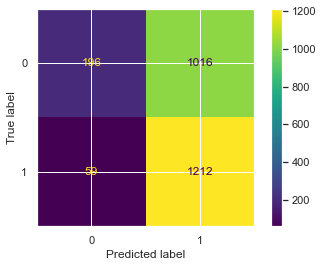

In [77]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

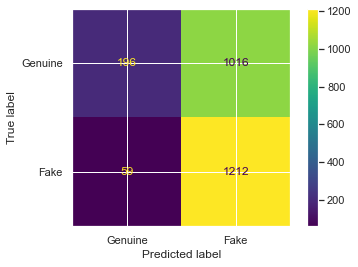

In [78]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [79]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 59
TP: 1212
TN: 196
FP: 1016


In [80]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.77      0.16      0.27      1212
           1       0.54      0.95      0.69      1271

    accuracy                           0.57      2483
   macro avg       0.66      0.56      0.48      2483
weighted avg       0.65      0.57      0.49      2483



In [81]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5576480149981953


In [82]:
# Get baseline results
dt_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
dt_results

{'accuracy': 56.70559806685461,
 'precision': 0.5439856373429084,
 'recall': 0.953579858379229,
 'f1': 0.69276936267505}

In [83]:
model_results["Decision Tree Tuned"] = dt_results

In [84]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505}}

c) Random Forest Classifier

In [85]:
#creation of random forrest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1) #by default no of estimators=10
rf.fit(X_train, y_train)

#predictions on test data
preds_test= rf.predict(X_test)

In [86]:
#f1 score on test set
f1_score(y_test, preds_test)

0.6762870514820593

In [87]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6657269432138542
Precision score is: 0.6705336426914154
Recall score is: 0.6821400472069237
F1 score is: 0.6762870514820593


In [88]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[786 426]
 [404 867]]


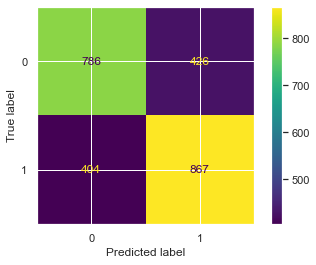

In [89]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

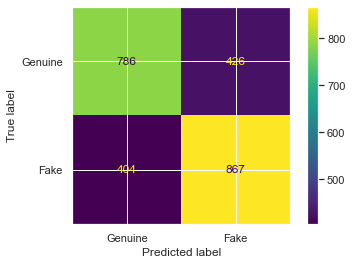

In [90]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [91]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 404
TP: 867
TN: 786
FP: 426


In [92]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      1212
           1       0.67      0.68      0.68      1271

    accuracy                           0.67      2483
   macro avg       0.67      0.67      0.67      2483
weighted avg       0.67      0.67      0.67      2483



In [93]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6653274493460362


In [94]:
# Get baseline results
rf_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
rf_results

{'accuracy': 66.57269432138541,
 'precision': 0.6705336426914154,
 'recall': 0.6821400472069237,
 'f1': 0.6762870514820593}

In [95]:
model_results["Random Forest"] = rf_results

In [96]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593}}

In [97]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [99]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

rf2 = RandomizedSearchCV(RandomForestClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=30, n_jobs=-1)

search = rf2.fit(X_train, y_train)

search.best_params_

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [100]:
optimal_params = search.best_params_
optimal_params

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [101]:
rf2 = RandomForestClassifier(random_state = 1, **optimal_params)
_ = rf2.fit(X_train, y_train)

#predictions on test data
preds_test= rf2.predict(X_test)



In [102]:
#f1 score on test set
f1_score(y_test, preds_test)

0.7049039288786922

In [103]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.585581957309706
Precision score is: 0.5546028880866426
Recall score is: 0.9669551534225019
F1 score is: 0.7049039288786922


In [104]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 225  987]
 [  42 1229]]


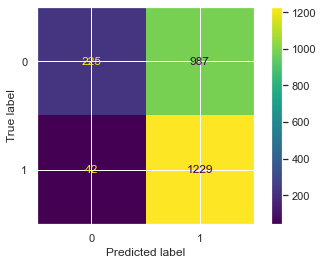

In [105]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

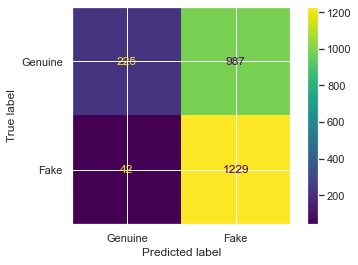

In [106]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [107]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 42
TP: 1229
TN: 225
FP: 987


In [108]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.84      0.19      0.30      1212
           1       0.55      0.97      0.70      1271

    accuracy                           0.59      2483
   macro avg       0.70      0.58      0.50      2483
weighted avg       0.70      0.59      0.51      2483



In [109]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5762993588894688


In [110]:
# Get baseline results
rf_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
rf_results

{'accuracy': 58.558195730970596,
 'precision': 0.5546028880866426,
 'recall': 0.9669551534225019,
 'f1': 0.7049039288786922}

In [111]:
model_results["Random Forest Tuned"] = rf_results

In [112]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922}}

In [139]:
'''
#Visualizing Feature Importance
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), trn[features].columns.values) #trn.columns has list of all columns in our training data
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rf2)    
'''

'\n#Visualizing Feature Importance\ndef plot_feature_importances(model):\n    n_features = X_train.shape[1]\n    plt.figure(figsize=(12,12))\n    plt.barh(range(n_features), model.feature_importances_, align=\'center\') \n    plt.yticks(np.arange(n_features), trn[features].columns.values) #trn.columns has list of all columns in our training data\n    plt.xlabel("Feature importance")\n    plt.ylabel("Feature")\n\nplot_feature_importances(rf2)    \n'

### d) Support Vector Machines

In [113]:
from sklearn.svm import SVC

svc = SVC(random_state = 1)
_ = svc.fit(X_train, y_train)

#predictions on test data
preds_test= svc.predict(X_test)

In [114]:
#f1 score on test set
f1_score(y_test, preds_test)

0.6850299401197605

In [115]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6822392267418446
Precision score is: 0.6952998379254457
Recall score is: 0.6750590086546027
F1 score is: 0.6850299401197605


In [116]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[836 376]
 [413 858]]


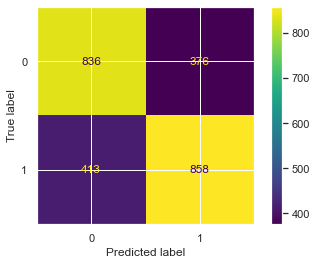

In [117]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

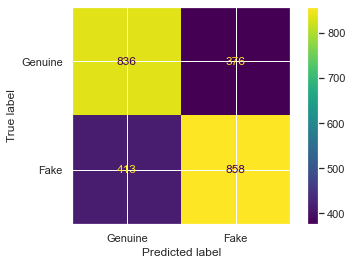

In [118]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [119]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 413
TP: 858
TN: 836
FP: 376


In [120]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1212
           1       0.70      0.68      0.69      1271

    accuracy                           0.68      2483
   macro avg       0.68      0.68      0.68      2483
weighted avg       0.68      0.68      0.68      2483



In [121]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6824139927761462


In [122]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 68.22392267418445,
 'precision': 0.6952998379254457,
 'recall': 0.6750590086546027,
 'f1': 0.6850299401197605}

In [123]:
model_results["SVC"] = svc_results

In [124]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605}}

In [125]:
#current parameters
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [126]:
#Now we will do tuning of the hyper-parameters

In [127]:
# List of C values
C_range = np.logspace(-10, 10, 21)
print(f'The list of values for C are {C_range}')

# List of gamma values
gamma_range = np.logspace(-10, 10, 21)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]
The list of values for gamma are [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]


In [128]:
from sklearn.model_selection import RandomizedSearchCV

# Define the search space

hyperparam_combs = {
    
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
}


svc2 = RandomizedSearchCV(SVC(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=10, n_jobs=-1)

search = svc2.fit(X_train, y_train)

search.best_params_

KeyboardInterrupt: 

In [ ]:
optimal_params = search.best_params_
optimal_params

In [ ]:
svc2 = SVC(random_state = 1, **optimal_params)
_ = svc2.fit(X_train, y_train)

#predictions on test data
preds_test= svc2.predict(X_test)



In [ ]:
#f1 score on test set
f1_score(y_test, preds_test)

0.7056808449900085

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5847764800644382
Precision score is: 0.553763440860215
Recall score is: 0.9724626278520849
F1 score is: 0.7056808449900085


In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 216  996]
 [  35 1236]]


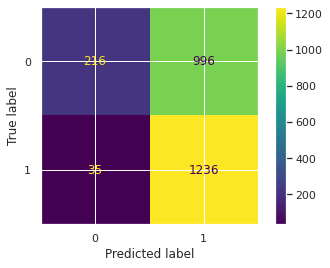

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

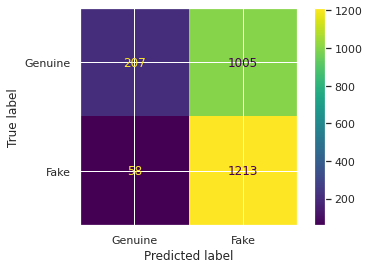

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 35
TP: 1236
TN: 216
FP: 996


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.86      0.18      0.30      1212
           1       0.55      0.97      0.71      1271

    accuracy                           0.58      2483
   macro avg       0.71      0.58      0.50      2483
weighted avg       0.70      0.58      0.51      2483



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5753402248171315


In [ ]:
# Get baseline results
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 58.477648006443815,
 'precision': 0.553763440860215,
 'recall': 0.9724626278520849,
 'f1': 0.7056808449900085}

In [ ]:
model_results["SVC Tuned"] = 

In [129]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605}}

### Support Vector Machines: Other Variants

In [130]:
from sklearn.svm import LinearSVC, NuSVC, SVC

#### 1. Linear SVC

In [240]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state = 1)
_ = svc.fit(X_train, y_train)

In [241]:
#predictions on test data
preds_test= svc.predict(X_test)

In [242]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6682711592458885


In [243]:
# Tuning on C hyperparameter
for c in range(1, 21, 1):
    c = c / 10
    svc = LinearSVC(random_state = 1, C=c)
    _ = svc.fit(X_train, y_train)
    preds_test= svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    print(c, f1_value)

0.1 0.6796273795058728
0.2 0.6822204344328239
0.3 0.685415829650462
0.4 0.6787003610108302
0.5 0.677341873498799
0.6 0.6733386709367495
0.7 0.6722689075630252
0.8 0.6717373899119295
0.9 0.6698756518251103
1.0 0.6682711592458885
1.1 0.6696
1.2 0.6719872306464486
1.3 0.6712
1.4 0.6722621902478019
1.5 0.6717373899119295
1.6 0.670404485382459
1.7 0.6696
1.8 0.6680016019223068
1.9 0.6663996796155387
2.0 0.6650660264105642


In [244]:
lin_svc = LinearSVC(random_state=1, C=0.3)
lin_svc = lin_svc.fit(X_train, y_train)

In [245]:
#predictions on test data
preds_test= lin_svc.predict(X_test)

In [246]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.685415829650462


In [247]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.684655658477648
Precision score is: 0.7003284072249589
Recall score is: 0.6711250983477577
F1 score is: 0.685415829650462


Confusion Matrix is:
[[847 365]
 [418 853]]


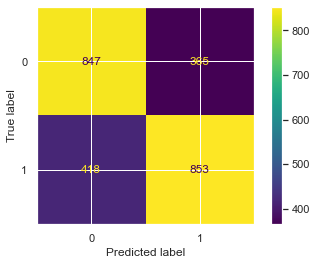

In [248]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [249]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1212
           1       0.70      0.67      0.69      1271

    accuracy                           0.68      2483
   macro avg       0.68      0.68      0.68      2483
weighted avg       0.69      0.68      0.68      2483



In [250]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6849849914181032


In [251]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 68.4655658477648,
 'precision': 0.7003284072249589,
 'recall': 0.6711250983477577,
 'f1': 0.685415829650462}

In [252]:
model_results["Linear SVC Tuned"] = svc_results

In [253]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

#### 2. NuSVR

In [145]:
nu_svc = NuSVC()
nu_svc = nu_svc.fit(X_train, y_train)

In [146]:
#predictions on test data
preds_test= nu_svc.predict(X_test)

In [147]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6843373493975904


In [148]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6834474426097463
Precision score is: 0.6989335520918786
Recall score is: 0.6703383162863886
F1 score is: 0.6843373493975904


Confusion Matrix is:
[[845 367]
 [419 852]]


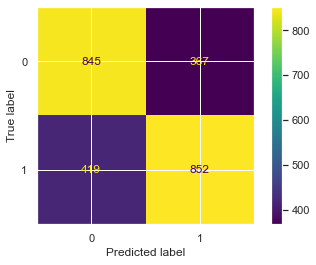

In [149]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [150]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1212
           1       0.70      0.67      0.68      1271

    accuracy                           0.68      2483
   macro avg       0.68      0.68      0.68      2483
weighted avg       0.68      0.68      0.68      2483



In [151]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6837665178791679


In [152]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 68.34474426097464,
 'precision': 0.6989335520918786,
 'recall': 0.6703383162863886,
 'f1': 0.6843373493975904}

In [153]:
model_results["Nu SVC"] = svc_results

In [154]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

In [155]:
# Tuning on the type of kernel for NuSVC
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    nu_svc = NuSVC(random_state = 1, kernel=kernel)
    nu_svc = nu_svc.fit(X_train, y_train)
    preds_test= nu_svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    print(kernel, f1_value)

linear 0.6653290529695024
poly 0.5849143914854235
rbf 0.6843373493975904
sigmoid 0.6565008025682182


In [186]:
nu_svc = NuSVC(random_state = 1, kernel='linear') #default was rbf only, so 2nd best is linear. Let's try it also
nu_svc = nu_svc.fit(X_train, y_train)

In [187]:
#predictions on test data
preds_test= nu_svc.predict(X_test)

In [188]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)

In [189]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6641159887233186
Precision score is: 0.678951678951679
Recall score is: 0.6522423288749016
F1 score is: 0.6653290529695024


Confusion Matrix is:
[[820 392]
 [442 829]]


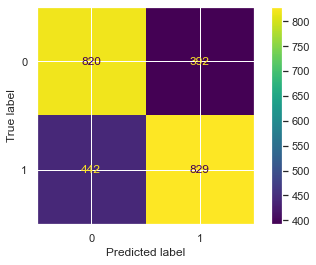

In [190]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [191]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.65      0.68      0.66      1212
           1       0.68      0.65      0.67      1271

    accuracy                           0.66      2483
   macro avg       0.66      0.66      0.66      2483
weighted avg       0.66      0.66      0.66      2483



In [192]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6644049928202892


In [193]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 66.41159887233185,
 'precision': 0.678951678951679,
 'recall': 0.6522423288749016,
 'f1': 0.6653290529695024}

In [194]:
model_results["Nu SVC Tuned"] = svc_results

In [195]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

In [ ]:
#Worse after tuning

#### 3. RBF-Kernel SVR

In [166]:
rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(X_train, y_train)

SVC()

In [167]:
#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [168]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6850299401197605


In [169]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6822392267418446
Precision score is: 0.6952998379254457
Recall score is: 0.6750590086546027
F1 score is: 0.6850299401197605


Confusion Matrix is:
[[836 376]
 [413 858]]


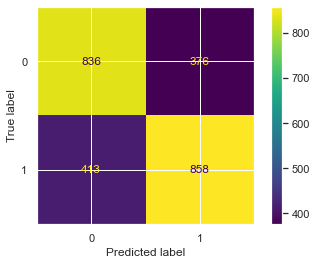

In [170]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [171]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1212
           1       0.70      0.68      0.69      1271

    accuracy                           0.68      2483
   macro avg       0.68      0.68      0.68      2483
weighted avg       0.68      0.68      0.68      2483



In [172]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6824139927761462


In [173]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 68.22392267418445,
 'precision': 0.6952998379254457,
 'recall': 0.6750590086546027,
 'f1': 0.6850299401197605}

In [174]:
model_results["RBF Kernel SVC"] = svc_results

In [196]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

**Now we will tune the 'C' parameter for RBF Kernel SVC.**

In [197]:
svc_rbf_c_results = {}

In [198]:
for c in range(2, 41, 2):
    c = c / 10
    rbf_svc = SVC(kernel="rbf",C=c)
    rbf_svc = rbf_svc.fit(X_train, y_train)

    #predictions on test data
    preds_test= rbf_svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    #print(f1_value)
    
    svc_rbf_c_results[c] = f1_value
    print(c, f1_value)

0.2 0.62916486369537
0.4 0.6816923685251087
0.6 0.6853977047882867
0.8 0.6894360603653694
1.0 0.6850299401197605
1.2 0.681107099879663
1.4 0.6784708249496981
1.6 0.6827115924588848
1.8 0.6824378508420208
2.0 0.6838087585375653
2.2 0.6838087585375653
2.4 0.683005222981117
2.6 0.6838087585375653
2.8 0.6838087585375653
3.0 0.6838087585375653
3.2 0.6835341365461847
3.4 0.6838087585375653
3.6 0.6832597350461662
3.8 0.683005222981117
4.0 0.683005222981117


In [199]:
sorted(svc_rbf_c_results.items(), key=lambda x: x[1])[-1]

(0.8, 0.6894360603653694)

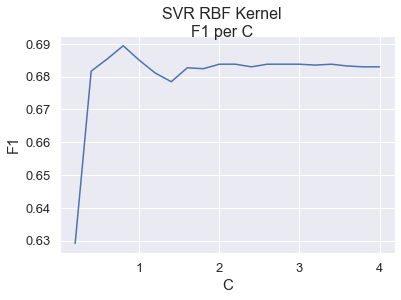

In [200]:
svc_rbf_c_results_df = (
    pd.DataFrame(svc_rbf_c_results.items(), columns=["C", "F1"])
    .sort_values("C")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="C", y="F1", data=svc_rbf_c_results_df, color="b")
plt.suptitle("SVR RBF Kernel\nF1 per C", fontsize=16)
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("F1", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

#### SVM Model with best hyperparameters:

In [201]:
rbf_svc = SVC(kernel="rbf",C=0.8)
rbf_svc = rbf_svc.fit(X_train, y_train)

#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [202]:
#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [203]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6894360603653694


In [204]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6850583971002819
Precision score is: 0.6960705693664796
Recall score is: 0.6829268292682927
F1 score is: 0.6894360603653694


Confusion Matrix is:
[[833 379]
 [403 868]]


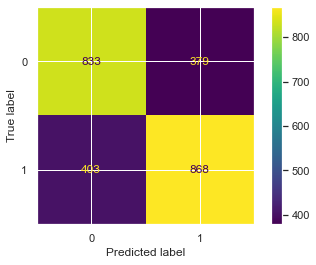

In [205]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [206]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1212
           1       0.70      0.68      0.69      1271

    accuracy                           0.69      2483
   macro avg       0.69      0.69      0.68      2483
weighted avg       0.69      0.69      0.69      2483



In [207]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6851102793206151


In [208]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 68.5058397100282,
 'precision': 0.6960705693664796,
 'recall': 0.6829268292682927,
 'f1': 0.6894360603653694}

In [209]:
model_results["RBF Kernel SVC Tuned"] = svc_results

In [210]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

### e) XGBoost Model

In [211]:
import xgboost as xgb

In [212]:
# define model
xgb = xgb.XGBClassifier()
xgb = xgb.fit(X_train, y_train)

In [213]:
#predictions on test data
preds_test= xgb.predict(X_test)

In [214]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6952309985096871


In [215]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6705598066854611
Precision score is: 0.6602972399150743
Recall score is: 0.7340676632572777
F1 score is: 0.6952309985096871


Confusion Matrix is:
[[732 480]
 [338 933]]


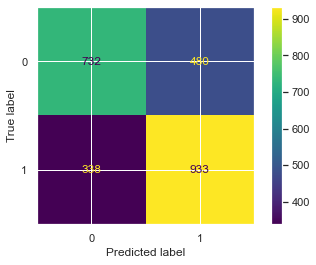

In [216]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [217]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      1212
           1       0.66      0.73      0.70      1271

    accuracy                           0.67      2483
   macro avg       0.67      0.67      0.67      2483
weighted avg       0.67      0.67      0.67      2483



In [218]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6690140296484408


In [219]:
xgb_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
xgb_results

{'accuracy': 67.05598066854611,
 'precision': 0.6602972399150743,
 'recall': 0.7340676632572777,
 'f1': 0.6952309985096871}

In [220]:
model_results["XGBoost"] = xgb_results

In [221]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

In [222]:
#Hyper-parameter Tuning on XGBoost

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbc = xgb.XGBClassifier(seed = 20)

clf = RandomizedSearchCV(estimator=xgbc,
                         param_distributions=params,
                         scoring='f1',
                         n_iter=10,
                         verbose=1)


clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=100, n_jobs=None,
                                         

In [223]:
print("Best parameters:", clf.best_params_)
print("Highest F1: ", (clf.best_score_))

Best parameters: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}
Highest F1:  0.6754141144739554


In [224]:
# define best model
xgb_tuned = xgb.XGBClassifier(subsample= 0.7, n_estimators= 1000, max_depth= 5, learning_rate= 0.01, colsample_bytree= 0.4, colsample_bylevel= 0.4)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.4, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [225]:
#predictions on test data
preds_test= xgb_tuned.predict(X_test)

In [226]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.704397981254506


In [227]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6697543294401933
Precision score is: 0.6500332667997338
Recall score is: 0.7686860739575138
F1 score is: 0.704397981254506


Confusion Matrix is:
[[686 526]
 [294 977]]


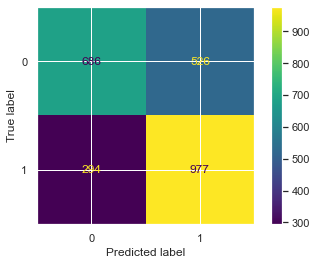

In [228]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [229]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1212
           1       0.65      0.77      0.70      1271

    accuracy                           0.67      2483
   macro avg       0.68      0.67      0.67      2483
weighted avg       0.67      0.67      0.67      2483



In [230]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6673463373087899


In [231]:
xgb_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
xgb_results

{'accuracy': 66.97543294401933,
 'precision': 0.6500332667997338,
 'recall': 0.7686860739575138,
 'f1': 0.704397981254506}

In [232]:
model_results["XGBoost Tuned"] = xgb_results

In [261]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

### f) Stacking Classifier Model

In [260]:
from sklearn.ensemble import StackingClassifier

level0 = list()
level0.append(('rbf-svc',SVC(kernel="rbf",C=0.8)))
level0.append(('linear-svc', LinearSVC(random_state=1, C=0.3)))
level0.append(('xgb', xgb.XGBClassifier(subsample= 0.7, n_estimators= 1000, max_depth= 5, learning_rate= 0.01, colsample_bytree= 0.4, colsample_bylevel= 0.4)))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# fit the model on all available data
model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rbf-svc', SVC(C=0.8)),
                               ('linear-svc', LinearSVC(C=0.3, random_state=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=0.4,
                                              colsample_bynode=None,
                                              colsample_bytree=0.4,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, gro...
                                              importance_type=None,
                                

In [263]:
#predictions on test data
preds_test= model.predict(X_test)

#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6924290220820188


In [264]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6858638743455497
Precision score is: 0.6940711462450593
Recall score is: 0.6907946498819827
F1 score is: 0.6924290220820188


Confusion Matrix is:
[[825 387]
 [393 878]]


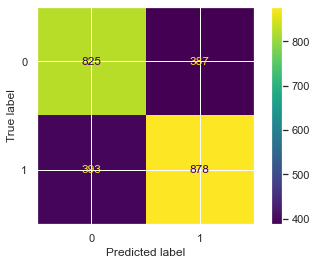

In [265]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [266]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)

# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1212
           1       0.69      0.69      0.69      1271

    accuracy                           0.69      2483
   macro avg       0.69      0.69      0.69      2483
weighted avg       0.69      0.69      0.69      2483



In [267]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))



AUC on Test data is 0.6857438595944566


In [268]:
stacking_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
stacking_results



{'accuracy': 68.58638743455498,
 'precision': 0.6940711462450593,
 'recall': 0.6907946498819827,
 'f1': 0.6924290220820188}

In [269]:
model_results["Stacking"] = stacking_results

model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Logistic Regression': {'accuracy': 67.90173177607733,
  'precision': 0.6984924623115578,
  'recall': 0.6561762391817466,
  'f1': 0.6766734279918863},
 'Decision Tree': {'accuracy': 58.679017317760774,
  'precision': 0.59592795614722,
  'recall': 0.5987411487018096,
  'f1': 0.597331240188383},
 'Decision Tree Tuned': {'accuracy': 56.70559806685461,
  'precision': 0.5439856373429084,
  'recall': 0.953579858379229,
  'f1': 0.69276936267505},
 'Random Forest': {'accuracy': 66.57269432138541,
  'precision': 0.6705336426914154,
  'recall': 0.6821400472069237,
  'f1': 0.6762870514820593},
 'Random Forest Tuned': {'accuracy': 58.558195730970596,
  'precision': 0.5546028880866426,
  'recall': 0.9669551534225019,
  'f1': 0.7049039288786922},
 'SVC': {'accuracy': 68.22392267418445,
  'precision': 0.6952998379254457,
  'recall': 0.6750590086546027,
  'f1': 0.6850299401197605},
 'Linear SVC Tuned': {'a

In [ ]:
#Not the best f1 but best balance bw precision and recall

In [270]:
preds_test

array([0, 0, 0, ..., 0, 0, 1])

In [271]:
y_test

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

In [272]:
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


In [273]:
# Saving Results to a CSV
def preds_to_csv(df, predictions, file_name="output.csv"):
    final_df = pd.DataFrame(df)
    final_df["pred"] = predictions
    final_df.to_csv(file_name, index=False)
    return f"Final Predictions saved to: {file_name}"

In [274]:
preds_to_csv(test_df, preds_test,"tfidf-output.csv")

'Final Predictions saved to: tfidf-output.csv'